In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [3]:
mat_file1 = io.loadmat('2014_Dataset1.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']

In [4]:
def make_input_output(p1,p2):
    global k
    for i in range(len(p1)-10):
        for j in range(20):
            if i==0:
                if j==0:
                    auto_input = p1[0]
                elif 1<= j <= 9:
                    auto_input = np.hstack((auto_input,p1[j]))
                else:
                    auto_input = np.hstack((auto_input,p2[j-10]))
            else:
                if j==0:
                    k = p1[i]
                elif 1<= j <= 9:
                    k = np.hstack((k,p1[j+i]))
                else:
                    k = np.hstack((k,p2[j-10+i]))
        if i != 0:           
            auto_input = np.vstack((auto_input,k))
        
        if i==0:
            auto_output1 = p1[10]
            auto_output2 = p2[10]
        else:
            auto_output1 = np.vstack((auto_output1,p1[10+i]))
            auto_output2 = np.vstack((auto_output2,p2[10+i]))               
        
    return auto_input,auto_output1,auto_output2 

In [5]:
i,o1,o2 = make_input_output(p1,p2)

In [18]:
i.reshape(1,-1)

array([[   5.819,    5.825,    5.835, ...,  195.   ,  195.91 ,  194.26 ]])

In [7]:
o1,o2

(array([[ 5.874],
        [ 5.862],
        [ 5.871],
        ..., 
        [ 5.984],
        [ 5.957],
        [ 5.954]]), array([[ 203.42],
        [ 203.24],
        [ 202.87],
        ..., 
        [ 195.91],
        [ 194.26],
        [ 193.53]]))

In [8]:
l = 300
K1 = GPy.kern.RBF(input_dim=20)
lcm = GPy.util.multioutput.LCM(input_dim=20,num_outputs=2,kernels_list=[K1])
ar_gp = GPy.models.GPCoregionalizedRegression([i[0:l],i[0:l]],[o1[0:l],o2[0:l]],kernel = lcm)
ar_gp.optimize()

In [9]:
ind = np.arange(10,10+l,1)[:,None]

for j in range(len(ind)):
    X,Y,I = build_XY([i[j:j+1],i[j:j+1]],[o1[j],o2[j]])
    mean, var = ar_gp.predict(X,Y_metadata=I,kern=ar_gp.kern,likelihood=ar_gp.likelihood)
    mean = np.hstack((mean[0],mean[1]))
    if j==0:
        output = mean
    else:
        output = np.vstack((output,mean))

In [20]:
for j in range(len(ind)):
    if j==0:
        bi = i[j:j+1].copy()
    else:
        bii = bi.copy()
        bi = bi.copy()
        bi[0][0:9] = bii[0][1:10]
        bi[0][9] = mean_b[0]
        bi[0][10:19] = bii[0][11:20]
        bi[0][19] = mean_b[1]

    X_b,Y_b,I_b = build_XY([bi,bi],[o1[j],o2[j]])
    mean_b, var_b = ar_gp.predict(X_b,Y_metadata=I_b)
    print(var_b)
    mean_b = np.hstack((mean_b[0],mean_b[1]))
    if j==0:
        output_b = mean_b
    else:
        output_b = np.vstack((output_b,mean_b))

[[  3.25341294e-04]
 [  7.60290284e-01]]
[[  3.25362278e-04]
 [  7.60308626e-01]]
[[  3.25111141e-04]
 [  7.59989452e-01]]
[[  3.24712520e-04]
 [  7.59321669e-01]]
[[  3.24283326e-04]
 [  7.58584119e-01]]
[[  3.24229542e-04]
 [  7.58617704e-01]]
[[  3.23881519e-04]
 [  7.57848407e-01]]
[[  3.23754844e-04]
 [  7.57966796e-01]]
[[  3.23304739e-04]
 [  7.57398666e-01]]
[[  3.21693624e-04]
 [  7.54304931e-01]]
[[  3.21538034e-04]
 [  7.54091098e-01]]
[[  3.21489839e-04]
 [  7.53993700e-01]]
[[  3.21456544e-04]
 [  7.53924350e-01]]
[[  3.21450519e-04]
 [  7.53907996e-01]]
[[  3.21385647e-04]
 [  7.53785536e-01]]
[[  3.21362407e-04]
 [  7.53746243e-01]]
[[  3.21315172e-04]
 [  7.53672547e-01]]
[[  3.21299441e-04]
 [  7.53637733e-01]]
[[  3.21283929e-04]
 [  7.53599015e-01]]
[[  3.21215360e-04]
 [  7.53514377e-01]]
[[  3.21200896e-04]
 [  7.53480530e-01]]
[[  3.21172185e-04]
 [  7.53432348e-01]]
[[  3.21146733e-04]
 [  7.53390346e-01]]
[[  3.21127641e-04]
 [  7.53352257e-01]]
[[  3.21101040e-

In [17]:
ar_gp

gp.,value,constraints,priors
ICM0.rbf.variance,112.847881648,+ve,
ICM0.rbf.lengthscale,1570.52978768,+ve,
ICM0.B.W,"(2, 1)",,
ICM0.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.000318969330413,+ve,
mixed_noise.Gaussian_noise_1.variance,0.750438726359,+ve,


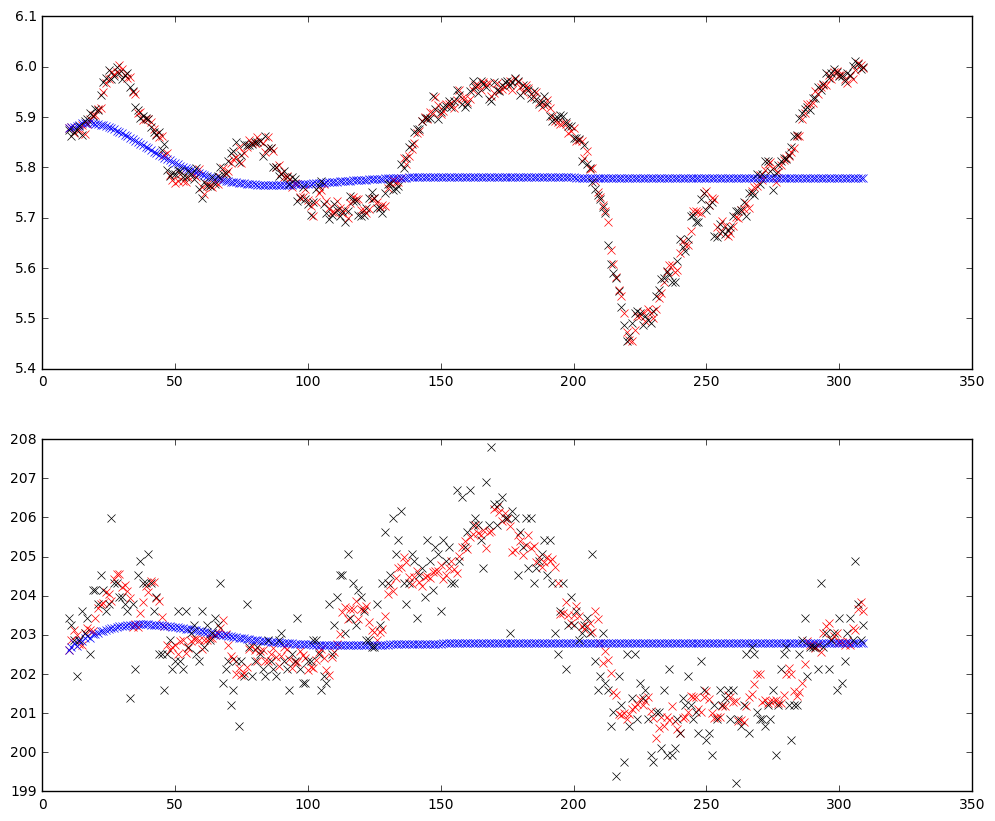

In [11]:
fig = pb.figure(figsize=(12,10))

ax1 = fig.add_subplot(211)
ax1.plot(ind,output[:,0],'kx',color='red')
ax1.plot(ind,output_b[:,0],'kx',color='blue')
ax1.plot(ind,o1[0:l],'kx')
ax2 = fig.add_subplot(212)
ax2.plot(ind,output[:,1],'kx',color='red')
ax2.plot(ind,output_b[:,1],'kx',color='blue')
ax2.plot(ind,o2[0:l],'kx')

plt.show()

In [119]:
output_b

array([[   5.87324701,  202.74637118],
       [   5.86990132,  202.46480192],
       [   5.86623227,  202.33599389],
       [   5.86270466,  202.22199032],
       [   5.86085565,  202.20679569],
       [   5.86070135,  202.25703572],
       [   5.85866832,  202.31415969],
       [   5.85542473,  202.29079067],
       [   5.853765  ,  202.21084531],
       [   5.85242568,  202.18906109],
       [   5.85146752,  202.18263867],
       [   5.85080836,  202.18043643],
       [   5.85036129,  202.17949997],
       [   5.85005965,  202.17901037],
       [   5.84985648,  202.17871714],
       [   5.8497198 ,  202.17852916],
       [   5.84962792,  202.17840515],
       [   5.84956611,  202.17832244],
       [   5.84952446,  202.17826697],
       [   5.84949653,  202.17822963],
       [   5.84947775,  202.17820456],
       [   5.84946509,  202.17818771],
       [   5.84945657,  202.17817641],
       [   5.84945088,  202.17816879],
       [   5.84944707,  202.17816367],
       [   5.84944446,  2

In [16]:
X,Y,I = build_XY([i[0:2],i[0:2]],[i[0:2],i[0:2]])
ar_gp.kern.K(X)/1000

array([[ 103.30625562,  103.30615429,   96.41064702,   96.41055246],
       [ 103.30615429,  103.30625562,   96.41055246,   96.41064702],
       [  96.41064702,   96.41055246,  131.93463368,  131.93450427],
       [  96.41055246,   96.41064702,  131.93450427,  131.93463368]])